
<img src=https://www.iteda.cnea.gov.ar/sites/default/files/garland_iteda_logo.png align='left' height=115>

<img src=https://www.facet.unt.edu.ar/facetinforma/wp-content/uploads/sites/9/2015/11/it-OP1-Transparente.png align='right' height=115>


# Análisis Estadístico de Datos

# Ajuste del espectro con chi-cuadrado (no-lineal)

In [ ]:
import math
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [1]:
# Para cargar archivos alojados en Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

MessageError: ignored

In [2]:
# bajar módulo sda.py e importar
dat_fil_Gid2 = '1Wm3uae2m7ZwXsn_02ZE1Qv7F_TM-KClm'
downloaded2 = drive.CreateFile({'id':dat_fil_Gid2})
downloaded2.GetContentFile('sda.py')
import sda

NameError: ignored

## Datos

Datos bineados en $x = log_{10}(E/eV)$, y = número de eventos en el bin

In [ ]:
xdata = np.linspace(18.45, 20.45, 21)
ydata = np.array([13023, 7711, 4478, 3159, 2162, 1483, 1052, 699, 451, 323, 200, 110, 43, 28, 23, 5, 2, 0, 1, 0, 0])

In [ ]:
ndatos = len(xdata)
ndatos

21

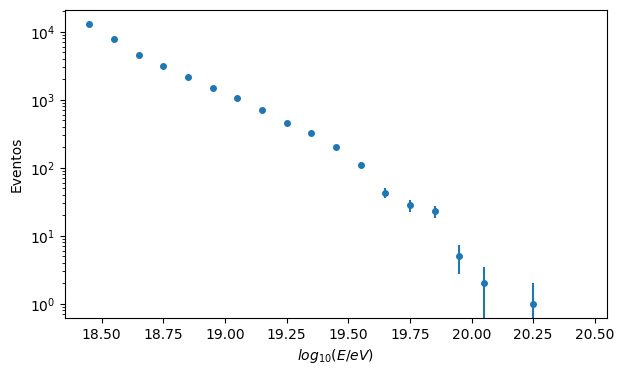

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel('$log_{10}(E/eV)$')
ax.set_ylabel('Eventos')
ax.set_yscale("log")
ysigma = np.sqrt(ydata)
ax.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='datos')
plt.show()

## Modelo

In [ ]:
def modelo(x, theta):
    return np.power(10, theta[0]-theta[1]*(x-19) )

## Función de costo

In [ ]:
def funcion_costo(theta, xdata, ydata):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta)
            residuo = y1 - mu1
            sigma_sqr = y1     # errores tomados de los datos (Pearson)
            costo += residuo**2 / sigma_sqr
        return costo

In [ ]:
xfit, yfit = xdata[3:11], ydata[3:11]

In [ ]:
xfit

array([18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45])

In [ ]:
yfit

array([3159, 2162, 1483, 1052,  699,  451,  323,  200])

In [ ]:
J = lambda theta: funcion_costo(theta, xfit, yfit)

## Minimización

In [ ]:
# La minimización no converge con la tolerancia por defecto
res = minimize(J, x0=(3, 2), tol=1e-6)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 4.508157233047166
        x: [ 3.086e+00  1.666e+00]
      nit: 7
      jac: [ 4.729e-04  2.551e-05]
 hess_inv: [[ 1.156e-05 -2.109e-05]
            [-2.109e-05  2.788e-04]]
     nfev: 142
     njev: 44

In [ ]:
# Hago la tolerancia menor al módulo del gradiente (jac)
res = minimize(J, x0=(3, 2), tol=1e-3)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.508157233047166
        x: [ 3.086e+00  1.666e+00]
      nit: 7
      jac: [ 4.729e-04  2.551e-05]
 hess_inv: [[ 1.156e-05 -2.104e-05]
            [-2.104e-05  2.786e-04]]
     nfev: 30
     njev: 10

### Estimadores

In [ ]:
theta_est = res.x

### Errores

In [ ]:
cova = 2*res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f'a = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a = 3.086 ± 0.005
b = 1.666 ± 0.024
ρ = -0.37


### Bondad del ajuste

In [ ]:
costo_min = res.fun
ndof = len(xfit) - len(theta_est)
pvalor = chi2.sf(costo_min, ndof)
print(f'χ²min = {costo_min:.2f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor*100:.1f}%')

χ²min = 4.51
ndof = 6
pvalor = 60.8%


## Figura ajuste

### Banda de error

In [ ]:
x = np.linspace( xfit.min(), xfit.max(), 256)
mu_est = modelo(x, theta_est)
grad_theta1 = math.log(10) * mu_est
grad_theta2 = (x-19) * math.log(10) * mu_est
grad = np.column_stack( (grad_theta1, grad_theta2) )
sigma_mu_est = sda.fit_errors(grad, cova)

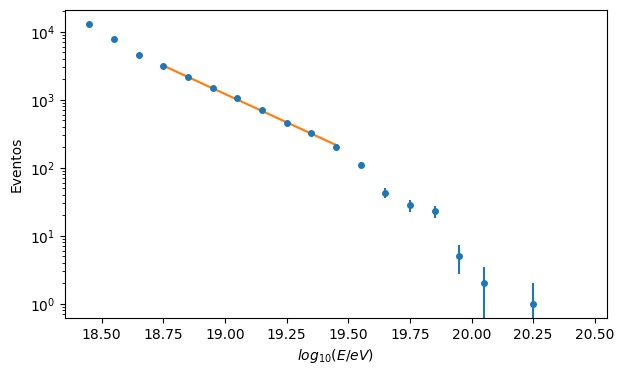

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel('$log_{10}(E/eV)$')
ax.set_ylabel('Eventos')
ax.set_yscale("log")
ysigma = np.sqrt(ydata)
ax.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='Datos')
ax.plot(x, mu_est, label='Ajuste')
ax.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)
plt.show()

La banda de error no se distingue en la figura (sigma_mu_est/mu_est ~ 2%)

## Figura parámetros

In [ ]:
theta1 = np.linspace(theta_est[0]-4*error[0] , theta_est[0]+4*error[0], 100)
theta2 = np.linspace(theta_est[1]-4*error[1] , theta_est[1]+4*error[1], 100)
theta1, theta2 = np.meshgrid(theta1, theta2)
theta = np.array([theta1, theta2])
z = J(theta)

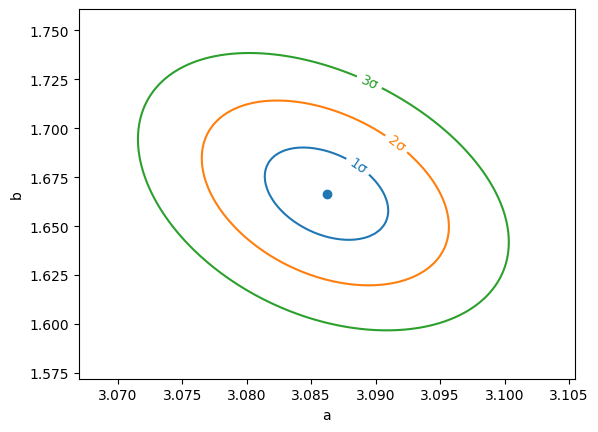

In [ ]:
fig, ax = plt.subplots()

# calculo de errores
levels = costo_min + np.array([1, 4, 9])
contour = ax.contour(theta1, theta2, z, levels, colors=['tab:blue', 'tab:orange', 'tab:green'])

fmt = {}
strs = ['1σ', '2σ', '3σ']
for l, s in zip(contour.levels, strs):
    fmt[l] = s
ax.clabel(contour, fmt=fmt)

ax.plot(*theta_est, 'o')

ax.set_xlabel('a')
ax.set_ylabel('b')
plt.show()